# Figure 2 - within subject encoding

In [27]:
import utils
import glob
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import permutation_test
from statsmodels.stats.multitest import multipletests
from nilearn.plotting import plot_markers
from util.ise import ROIS, ALL_ROIs, getMaps

from util.path import derivpath
from util.plot import formatenc
from utils import load_pickle
from constants import BLUE, RED

plt.style.use("presentation.mplstyle")

In [15]:
# Options
root = "../dataset/derivatives/encoding/"
Ss = [1, 2, 3, 4, 5, 6, 9, 10, 11, 12]
modes = ["prod", "comp"]

tmax, window, jump = 4, 0.250, 0.03125 * 2
lags = np.arange(-tmax, tmax + jump, jump)

rois = list(ROIS.keys())

models = []

# models.append('model-bert-large-wwm_layer-12_reg-l2')  # actual bert
# models.append('model-gpt2-xl_maxlen-0_reg-l2')  # static gpt2
# models.append("model-gpt2-xl_maxlen-1024_layer-24_random_reg-l2")  # untrained gpt2
# models.append('model-glove-300_reg-l2')  # glove
# models.append('model-symbolic_reg-l2')  # symbolic
# models.append('model-phonetic_reg-l2')  # articulatory
models.append("model-gpt2-xl_maxlen-1024_layer-24_reg-l2")  # actual gpt2

modelname = models[-1]
parts = utils.getparts(modelname)
shortname = "_".join(map(str, list(parts.values())[:4]))

print(modelname, shortname)

model-gpt2-xl_maxlen-1024_layer-24_reg-l2 gpt2-xl_1024_24_l2


In [16]:
root = "../dataset/derivatives/encoding_bands/"  # banded ridge regression
root = "../dataset/derivatives/encoding/"

# Load data

In [17]:
method, alpha = "fdr_bh", 0.01
datatype = f"method-{method}_alpha-{alpha}_lags-1"
sigmodelname = "model-gpt2-xl_maxlen-0_reg-l2_perm-phase"
p = derivpath(
    f"sub-all_model-{sigmodelname}.pkl",
    derivative="electrode-selection",
    datatype=datatype,
)
sigmasks = load_pickle(p)
sigmasks = {key[:2]: value for key, value in sigmasks.items()}
nsig_elecs = sum([s.sum() for s in sigmasks.values()])
nsig_elecs, sigmasks.keys()

(384,
 dict_keys([(1, 'prod'), (1, 'comp'), (2, 'prod'), (2, 'comp'), (3, 'prod'), (3, 'comp'), (4, 'prod'), (4, 'comp'), (5, 'prod'), (5, 'comp'), (6, 'prod'), (6, 'comp'), (9, 'prod'), (9, 'comp'), (10, 'prod'), (10, 'comp'), (11, 'prod'), (11, 'comp'), (12, 'prod'), (12, 'comp')]))

In [18]:
band = "highgamma"
# outdir = f'../results/paper/{sigmodelname}_method-{method}_alpha-{alpha}/{band}/{modelname}'
outdir = f"../results/paper/{sigmodelname}_method-{method}_alpha-{alpha}/{modelname}"
!mkdir -p {outdir}
outdir

'../results/paper/model-gpt2-xl_maxlen-0_reg-l2_perm-phase_method-fdr_bh_alpha-0.01/model-gpt2-xl_maxlen-1024_layer-24_reg-l2'

In [20]:
# Load actual results
import gc

results = {}
for sub in Ss:
    for mode in modes:
        for mname in models:
            actual_pickle = glob.glob(
                f"{root}sub-{sub:02d}/{mname}/sub-{sub:02d}_task-conversation_encoding_mode-{mode}.pkl"
            )

            # after adding band in filename
            # actual_pickle = glob.glob(
            #     f"{root}sub-{sub:02d}/{mname}/sub-{sub:02d}_task-conversation_encoding_mode-{mode}_band-{band}.pkl"
            # )
            if len(actual_pickle):
                print(sub, mode, mname)
                with open(actual_pickle[0], "rb") as f:
                    result = pickle.load(f)
                    # For encoding
                    del result['embs']
                    del result['df']
                    del result["args"]
                    del result["coefs"]
                    del result["preds"]
                    del result["true"]
                    results[(sub, mode, mname)] = result
                    gc.collect()
# print(result.keys())
# results.keys()
len(results)

1 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
1 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
2 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
2 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
3 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
3 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
4 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
4 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
5 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
5 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
6 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
6 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
9 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
9 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
10 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
10 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
11 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
11 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2
12 prod model-gpt2-xl_maxlen-1024_layer-24_reg-l2
12 comp model-gpt2-xl_maxlen-1024_layer-24_reg-l2


20

In [21]:
allcoords = utils.getallcoords(results, Ss, modelname)

Opening raw data file ../dataset/derivatives/preprocessed/sub-01/fastica/sub-01_task-conversation_desc-highgamma_ieeg.fif...
    Range : 0 ... 842751 =      0.000 ...  1645.998 secs
Ready.
Opening raw data file ../dataset/derivatives/preprocessed/sub-02/fastica/sub-02_task-conversation_desc-highgamma_ieeg.fif...
    Range : 0 ... 842751 =      0.000 ...  1645.998 secs
Ready.
Opening raw data file ../dataset/derivatives/preprocessed/sub-03/fastica/sub-03_task-conversation_desc-highgamma_ieeg.fif...
    Range : 0 ... 773119 =      0.000 ...  1509.998 secs
Ready.
Opening raw data file ../dataset/derivatives/preprocessed/sub-04/fastica/sub-04_task-conversation_desc-highgamma_ieeg.fif...
    Range : 0 ... 714239 =      0.000 ...  1394.998 secs
Ready.
Opening raw data file ../dataset/derivatives/preprocessed/sub-05/fastica/sub-05_task-conversation_desc-highgamma_ieeg.fif...
    Range : 0 ... 795647 =      0.000 ...  1553.998 secs
Ready.
Opening raw data file ../dataset/derivatives/preprocess

# plot brains at fixed lags

-1 -0.12363003 0.4242385 226 226
-0.5 -0.1891855 0.48864213 226 226
0 -0.08572967 0.4161841 226 226
0.5 -0.14435045 0.42923394 226 226
1 -0.09223592 0.35784617 226 226
-1 -0.1767391 0.29926547 158 158
-0.5 -0.14835742 0.42585486 158 158
0 -0.06394428 0.52759445 158 158
0.5 0.0054139784 0.511349 158 158
1 -0.026980769 0.3557415 158 158


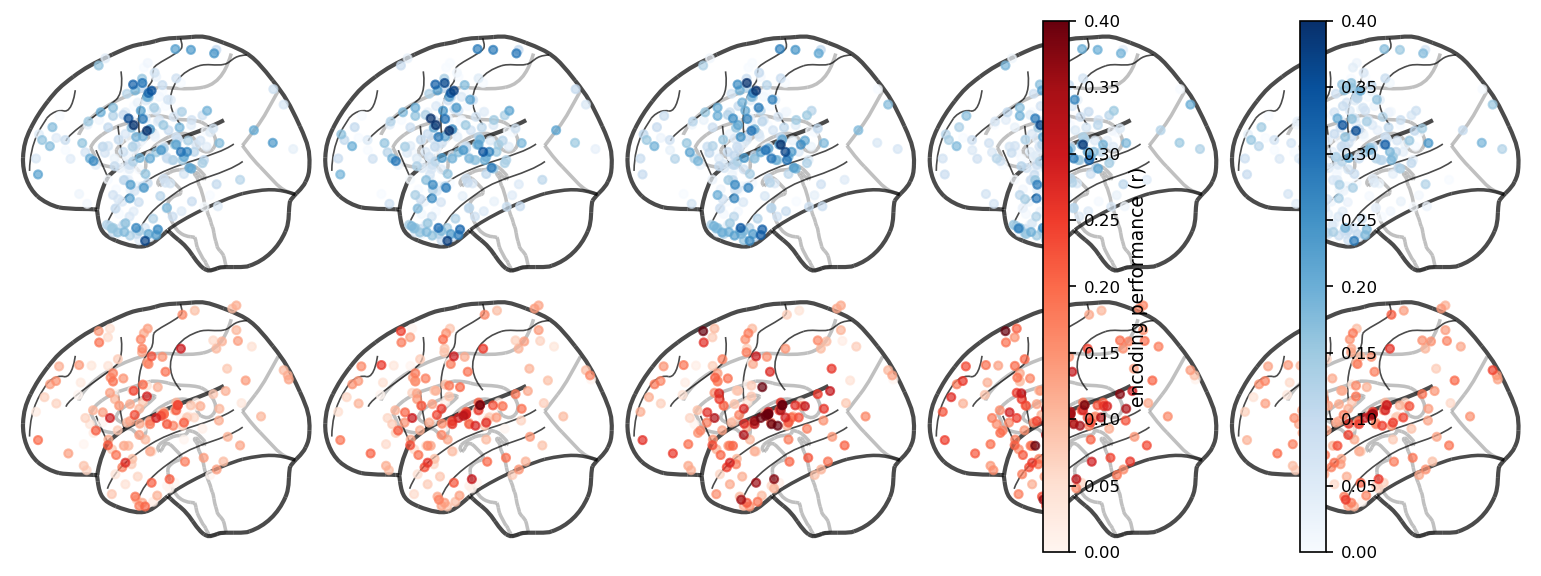

In [24]:
# plot_markers one axis is default to size [2.6, 2.3] in
vmin, vmax = 0, 0.3
vmin, vmax = 0, 0.4

sig = True
fig, axes = plt.subplots(2, 5, figsize=(2.6 * 5, 2.3 * 2))
fig.subplots_adjust(wspace=0, hspace=0)
for i, mode in enumerate(modes):
    # for j, sec in enumerate([-.5, -.25, 0, .25, .5]):
    for j, sec in enumerate([-1, -0.5, 0, 0.5, 1]):
        ax = axes[i, j]
        lag = (lags == sec).nonzero()[0].item()

        maxes = []
        coords = []
        for sub in Ss:
            corrs = np.mean(results[(sub, mode, modelname)]["corrs"], axis=0)[:, lag]
            mask = sigmasks[(sub, mode)] if sig else None
            coords.append(allcoords[sub][mask].squeeze())
            maxes.append(corrs[mask].squeeze())
        values = np.concatenate(maxes)
        coords = np.vstack(coords)
        order = np.argsort(values)
        print(sec, values.min(), values.max(), len(values), len(coords))
        plot_markers(
            values[order],
            coords[order],
            display_mode="l",
            figure=fig,
            axes=ax,
            node_vmax=vmax,
            node_vmin=vmin,
            node_size=15,
            colorbar=False,
            node_cmap="Reds" if i else "Blues",
        )

bar_norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
fig.colorbar(mpl.cm.ScalarMappable(norm=bar_norm, cmap="Blues"), ax=axes)
fig.colorbar(
    mpl.cm.ScalarMappable(norm=bar_norm, cmap="Reds"),
    label="encoding performance (r)",
    ax=axes,
)

# fig.suptitle(modelname)
# fig.savefig(f"{outdir}/fig2-encoding-brain-lags_sig-{sig}.svg")
plt.show()

# per ROI

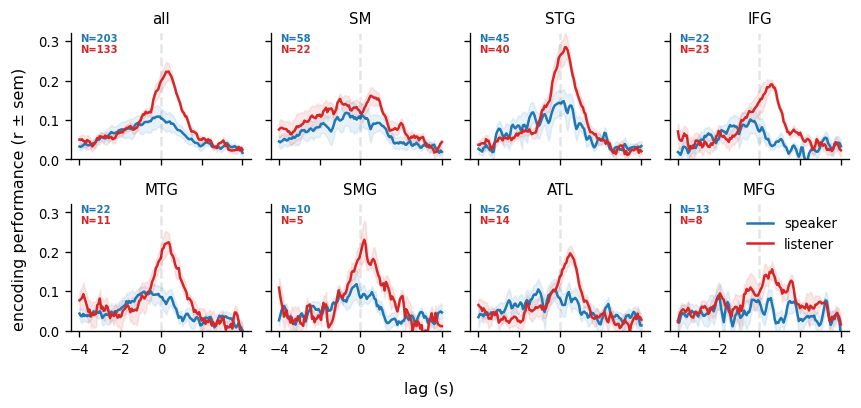

In [26]:
# Plot average per ROI
fig, axes = plt.subplots(
    2, 4, dpi=120, figsize=(7.24, 1.68 * 2), sharey=True, sharex=True
)

sig = None
sig = sigmasks

for roi, ax in zip(["all"] + rois[:-1], axes.flatten()):
    if roi != "all":
        MS, NS, _ = getMaps( results, Ss, modelname=modelname, speakerROI=ROIS[roi], partnerROI=ROIS[roi], mode="within-prod", significant=sig, reduce=False,)
        MP, _, NP = getMaps( results, Ss, modelname=modelname, speakerROI=ROIS[roi], partnerROI=ROIS[roi], mode="within-comp", significant=sig, reduce=False,)
    else:
        MS, NS, _ = getMaps( results, Ss, modelname=modelname, speakerROI=ALL_ROIs, partnerROI=ALL_ROIs, mode="within-prod", significant=sig, reduce=False,)
        MP, _, NP = getMaps( results, Ss, modelname=modelname, speakerROI=ALL_ROIs, partnerROI=ALL_ROIs, mode="within-comp", significant=sig, reduce=False,)

    if n := np.count_nonzero(NS):
        mean = np.ma.mean(MS, axis=0)
        err = np.ma.std(MS, axis=0) / np.sqrt(n)
        ax.plot(lags, mean, label="speaker", color=BLUE)
        ax.fill_between(lags, mean - err, mean + err, color=BLUE, alpha=0.1)

    if n := np.count_nonzero(NP):
        mean = np.ma.mean(MP, axis=0)
        err = np.ma.std(MP, axis=0) / np.sqrt(n)
        ax.plot(lags, mean, label="listener", color=RED)
        ax.fill_between(lags, mean - err, mean + err, color=RED, alpha=0.1)

    formatenc(ax)
    ax.text(0.05, 1, f"N={sum(NS)}", color=BLUE, transform=ax.transAxes, alpha=1, ha="left", va="top", weight="bold", fontsize=6,)
    ax.text(0.05, 0.91, f"N={sum(NP)}", color=RED, transform=ax.transAxes, alpha=1, ha="left", va="top", weight="bold", fontsize=6,)
    ax.set(title=roi)  # f'{roi} ({sum(NS)} {sum(NP)})')
    ax.set_ylim(0, 0.32)
    ax.set_xticks(lags[:: lags.size // 4])

axes[-1, -1].legend(loc="best", frameon=False)

fig.supylabel("encoding performance (r ± sem)")
fig.supxlabel("lag (s)")

fig.tight_layout()
# fig.savefig(f"{outdir}/fig2-encoding-rois_sig-{sig is not None}.svg")
plt.show()

# significant test of peaks and lags

In [28]:
def lag_diff_statistic(x, y, axis):
    # x, y shapes are (perms, lags, elecs)
    # average over elecs, then calc absdiff in peak lags
    return np.abs(
        np.argmax(np.mean(x, axis=axis), axis=-1)
        - np.argmax(np.mean(y, axis=axis), axis=-1)
    )


def mag_diff_statistic(x, y, axis):
    # x, y shapes are (perms, lags, elecs)
    # average over elecs, then calc diff in peaks
    return np.max(np.mean(x, axis=axis), axis=-1) - np.max(
        np.mean(y, axis=axis), axis=-1
    )

In [29]:
n_perms = 10000
n_perms = 1

records = []
sig = sigmasks
for roi in ["all"] + rois:
    if roi != "all":
        MS, NS, _ = getMaps( results, Ss, modelname=modelname, speakerROI=ROIS[roi], partnerROI=ROIS[roi], mode="within-prod", significant=sig, reduce=False, reduce_elecs=False,)
        MP, _, NP = getMaps( results, Ss, modelname=modelname, speakerROI=ROIS[roi], partnerROI=ROIS[roi], mode="within-comp", significant=sig, reduce=False, reduce_elecs=False,)
    else:
        MS, NS, _ = getMaps( results, Ss, modelname=modelname, speakerROI=ALL_ROIs, partnerROI=ALL_ROIs, mode="within-prod", significant=sig, reduce=False, reduce_elecs=False,)
        MP, _, NP = getMaps( results, Ss, modelname=modelname, speakerROI=ALL_ROIs, partnerROI=ALL_ROIs, mode="within-comp", significant=sig, reduce=False, reduce_elecs=False,)

    # Exclude all masked entries
    MS = MS[~MS.mask.any(-1)].data
    MP = MP[~MP.mask.any(-1)].data

    meanS = MS.mean(0)
    meanP = MP.mean(0)
    bestLagS = meanS.argmax()
    bestLagP = meanP.argmax()

    lag_permres = permutation_test( (MS, MP), statistic=lag_diff_statistic, vectorized=True, axis=0, permutation_type="independent", n_resamples=n_perms, alternative="greater",)
    mag_permres = permutation_test( (MS, MP), statistic=mag_diff_statistic, vectorized=True, axis=0, permutation_type="independent", n_resamples=n_perms,)
    records.append(
        {
            "roi": roi,
            "lag_prod": lags[bestLagS],
            "lag_comp": lags[bestLagP],
            "lag_diff": lag_permres.statistic * jump,
            "lag_pvalue_corr": lag_permres.pvalue,
            "mag_prod": meanS[bestLagS],
            "mag_comp": meanP[bestLagP],
            "mag_diff": mag_permres.statistic,
            "mag_pvalue_corr": mag_permres.pvalue,
        }
    )

df = pd.DataFrame(records)
df["lag_pvalue_corr"] = multipletests(df.lag_pvalue_corr.values, method="fdr_bh")[1]
df["mag_pvalue_corr"] = multipletests(df.mag_pvalue_corr.values, method="fdr_bh")[1]
# df['lag_pvalue_corr'] = [df.lag_pvalue_corr[0].item()] + multipletests(df.lag_pvalue_corr.values[1:], method='fdr_bh')[1].tolist()
# df['mag_pvalue_corr'] = [df.mag_pvalue_corr[0].item()] + multipletests(df.mag_pvalue_corr.values[1:], method='fdr_bh')[1].tolist()
df

,roi,lag_prod,lag_comp,lag_diff,lag_pvalue_corr,mag_prod,mag_comp,mag_diff,mag_pvalue_corr
0,all,-0.1875,0.3750,0.5625,0.642857,0.118195,0.215822,-0.097627,1.0
1,SM,-0.6875,-1.0000,0.3125,1.000000,0.130168,0.161090,-0.030922,1.0
2,STG,-0.1250,0.2500,0.3750,0.642857,0.144235,0.284147,-0.139912,1.0
3,IFG,-0.1875,0.3750,0.5625,0.642857,0.082744,0.193340,-0.110596,1.0
4,MTG,-0.9375,0.1875,1.1250,0.642857,0.104245,0.230524,-0.126278,1.0
5,SMG,-0.1875,0.1875,0.3750,1.000000,0.110399,0.205785,-0.095386,1.0
6,ATL,-0.1875,0.5000,0.6875,0.642857,0.143688,0.211782,-0.068094,1.0
7,MFG,-0.3125,0.6250,0.9375,0.642857,0.089980,0.165024,-0.075044,1.0
8,SFG,-1.5000,0.3750,1.8750,0.642857,0.147452,0.254191,-0.106739,1.0


# visualize brains

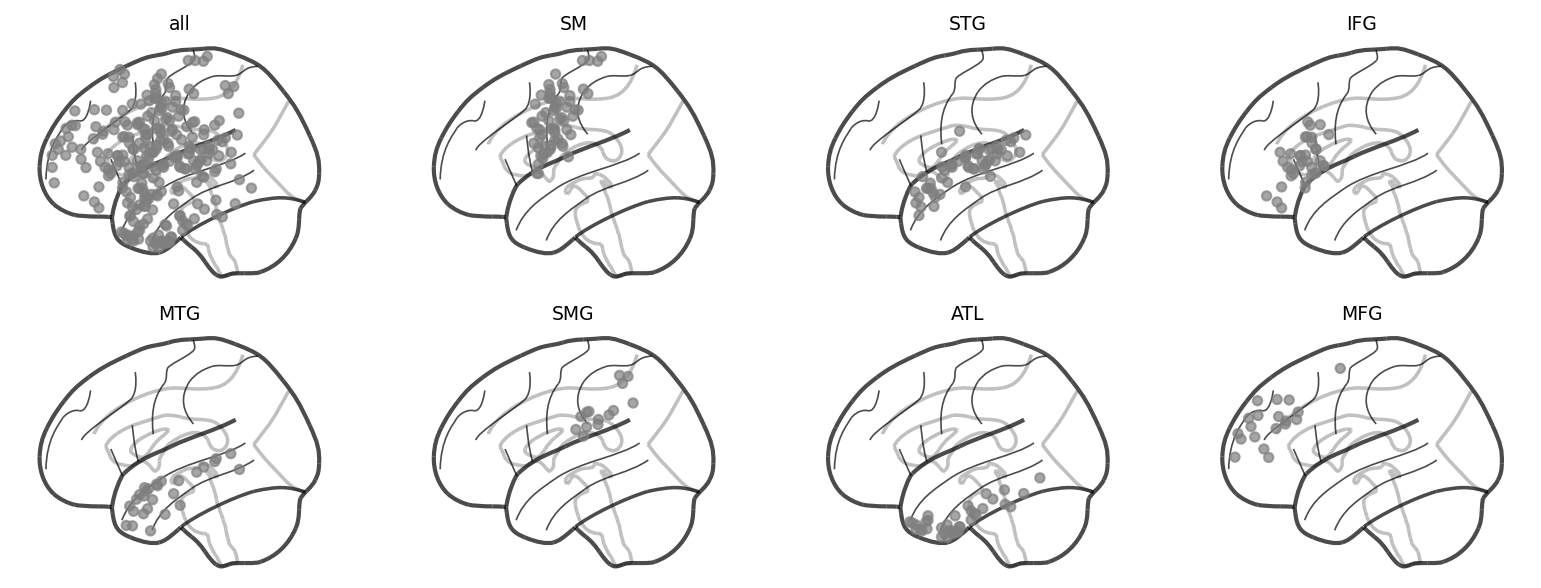

In [10]:
# Plot each ROI separately both prod + comp for shcematics mostly
# plot_markers one axis is default to size [2.6, 2.3] in
# fig, axes = plt.subplots(2, 4, dpi=120, figsize=(14, 4))
fig, axes = plt.subplots(2, 4, figsize=(2.6 * 5, 2.3 * 2))
for roi, ax in zip(["all"] + list(ROIS.keys()), axes.flatten()):
    maxes = []
    coords = []
    for sub in Ss:
        rois = ROIS[roi] if roi != "all" else sum(list(ROIS.values()), ())
        roimask = np.in1d(results[(sub, "prod", modelname)]["rois"], rois)
        mask = sigmasks[(sub, "prod")] & roimask
        mask |= sigmasks[(sub, "comp")] & roimask
        # corrs = np.mean(results[(sub, mode, modelname)]['corrs'], 0)
        coords.append(allcoords[sub][mask])
        # maxes.append(corrs.max(-1)[mask])

    # values = np.concatenate(maxes)
    coords = np.vstack(coords)
    values = np.ones(len(coords)) * 7
    if len(values) == 1:
        values = np.repeat(values, 2)
        coords = np.repeat(coords, 2, axis=0)

    order = np.argsort(values)
    # print(values.min(), values.max(), len(values))

    plot_markers(
        values[order],
        coords[order],
        display_mode="l",
        figure=fig,
        axes=ax,
        node_vmax=9,
        node_vmin=0,
        node_size=20,
        colorbar=False,
        node_cmap=mpl.colors.ListedColormap(sns.color_palette().as_hex()),
    )
    ax.set_title(roi)

fig.savefig(f"{outdir}/fig2-brain-roi-sig-schematics.svg")
plt.show()

# table: significant electrodes

In [7]:
# Load data
dfs = []
for (sub, mode, _), result in results.items():
    df = pd.DataFrame()
    df["electrode"] = result["electrodes"]
    df["roi"] = result["rois"]
    df["significant"] = sigmasks[(sub, mode)]
    df.insert(0, "mode", mode)
    df.insert(0, "subject", sub)
    dfs.append(df)

df = pd.concat(dfs)
roi2parcell = {roi: label for label, rois in ROIS.items() for roi in rois}
df["parcell"] = df.roi.apply(lambda x: roi2parcell.get(x, None))
df.dropna(inplace=True)
df

,subject,mode,electrode,roi,significant,parcell
0,1,prod,EEG GA_01-REF,RMF,True,MFG
1,1,prod,EEG GA_02-REF,RMF,False,MFG
2,1,prod,EEG GA_05-REF,RMF,False,MFG
3,1,prod,EEG GA_06-REF,CMF,False,MFG
4,1,prod,EEG GA_07-REF,PREC,True,SM
...,...,...,...,...,...,...
76,12,comp,EEG PT_03-REF,mMTG,False,MTG
77,12,comp,EEG PT_04-REF,mMTG,False,MTG
78,12,comp,EEG PT_05-REF,mSTG,True,STG
79,12,comp,EEG PT_06-REF,cSTG,True,STG


In [8]:
# per- subject, mode, and ROI significant electrodes
col = "parcell"
mask = df.significant
dfcounts = (
    df[mask]
    .groupby(["subject", "mode", "parcell"])
    .electrode.count()
    .to_frame()
    .reset_index()
)
pd.pivot(dfcounts, index=["subject", "mode"], columns=[col]).fillna(0).astype(int)

electrode                            
parcell            ATL IFG MFG MTG SFG  SM SMG STG
subject mode                                      
1       comp         0   2   2   0   0   4   0   3
        prod         1   1   2   1   1   5   0   0
2       comp         1   0   0   1   0   1   0   5
        prod         2   3   2   5   0  11   4   9
3       comp         2   4   0   1   0   4   2   4
        prod         0   1   0   1   0   4   0   1
4       comp         1   5   1   1   0   2   0   9
        prod         3   6   1   5   0   6   2  11
5       comp         1   3   0   0   0   1   1   1
        prod         1   0   1   0   0   2   0   1
6       comp         0   0   0   0   0   0   0   2
        prod         5   1   0   1   0   7   0   6
9       comp         5   4   1   4   5   2   1   3
        prod         2   1   0   1   2   1   0   2
10      comp         3   0   2   3   5   4   0   0
        prod         2   0   1   4   2   7   0   1
11      comp         0   1   1   1   0   3   1   9
        prod        10   7   4   3   2  13   2  10
12      comp         1   4   1   0   0   1   0   4
        prod         0   2   2   1   0   2   2   4

In [9]:
# Cleaned up version of previous
mode = "prod"
mask = df.significant & (df["mode"] == mode)
dfcounts = (
    df[mask].groupby(["subject", "parcell"]).electrode.count().to_frame().reset_index()
)
df1 = pd.pivot(dfcounts, index="subject", columns=[col]).fillna(0).astype(int)
df1.insert(0, "mode", mode)

mode = "comp"
mask = df.significant & (df["mode"] == mode)
dfcounts = (
    df[mask].groupby(["subject", "parcell"]).electrode.count().to_frame().reset_index()
)
df2 = pd.pivot(dfcounts, index="subject", columns=[col]).fillna(0).astype(int)
df2.insert(0, "mode", mode)

df3 = pd.concat((df1, df2))
df3.loc["Column_Total"] = df3.sum(numeric_only=True, axis=0).astype(int)
df3.loc[:, "Row_Total"] = df3.sum(numeric_only=True, axis=1).astype(int)

del df1, df2
df3 = df3.astype(int, errors="ignore")
df3

mode electrode                             Row_Total
parcell                  ATL IFG MFG MTG SFG  SM SMG STG          
subject                                                           
1             prod         1   1   2   1   1   5   0   0        11
2             prod         2   3   2   5   0  11   4   9        36
3             prod         0   1   0   1   0   4   0   1         7
4             prod         3   6   1   5   0   6   2  11        34
5             prod         1   0   1   0   0   2   0   1         5
6             prod         5   1   0   1   0   7   0   6        20
9             prod         2   1   0   1   2   1   0   2         9
10            prod         2   0   1   4   2   7   0   1        17
11            prod        10   7   4   3   2  13   2  10        51
12            prod         0   2   2   1   0   2   2   4        13
1             comp         0   2   2   0   0   4   0   3        11
2             comp         1   0   0   1   0   1   0   5         8
3             comp         2   4   0   1   0   4   2   4        17
4             comp         1   5   1   1   0   2   0   9        19
5             comp         1   3   0   0   0   1   1   1         7
6             comp         0   0   0   0   0   0   0   2         2
9             comp         5   4   1   4   5   2   1   3        25
10            comp         3   0   2   3   5   4   0   0        17
11            comp         0   1   1   1   0   3   1   9        16
12            comp         1   4   1   0   0   1   0   4        11
Column_Total   NaN        40  45  21  33  17  80  15  85       336

In [35]:
# How many electrodes are significant for comp/prod?
df2 = (
    df.groupby(["subject", "electrode", "mode"], sort=False)
    .significant.sum()
    .unstack("mode")
)
df2["both"] = df2["comp"] & df2["prod"]
df2["only_comp"] = df2["comp"] & (~df2["prod"])
df2["only_prod"] = df2["prod"] & (~df2["comp"])
df2.sum()

mode
prod         203
comp         133
both          69
only_comp     64
only_prod    134
dtype: int64

In [33]:
# Load data
records = []
for (sub, mode, _), result in results.items():
    roilist = sum([list(v) for v in ROIS.values()], [])
    roimask = np.in1d(result["rois"], roilist)
    sig_elecs = np.array(result["electrodes"])[sigmasks[(sub, mode)] & roimask]
    n_depth = sum([e[4:].startswith("D") for e in sig_elecs])
    n_grid = sum([e[4:].startswith("G") for e in sig_elecs])
    n_strip = len(sig_elecs) - n_depth - n_grid
    records.append((sub, mode, len(sig_elecs), n_grid, n_strip, n_depth))

df_etype = pd.DataFrame(
    records, columns=["sub", "mode", "all", "grid", "strip", "depth"]
)
df_etype.loc["Column_Total"] = df_etype.sum(numeric_only=True, axis=0).astype(int)
df_etype.loc[:, "Row_Total"] = df_etype.sum(numeric_only=True, axis=1).astype(int)
df_etype

,sub,mode,all,grid,strip,depth,Row_Total
0,1.0,prod,11.0,9.0,2.0,0.0,23
1,1.0,comp,11.0,11.0,0.0,0.0,23
2,2.0,prod,36.0,34.0,2.0,0.0,74
3,2.0,comp,8.0,7.0,1.0,0.0,18
4,3.0,prod,7.0,6.0,0.0,1.0,17
5,3.0,comp,17.0,9.0,3.0,5.0,37
6,4.0,prod,34.0,27.0,4.0,3.0,72
7,4.0,comp,19.0,17.0,2.0,0.0,42
8,5.0,prod,5.0,4.0,1.0,0.0,15
9,5.0,comp,7.0,6.0,1.0,0.0,19
